In [5]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [6]:
!pip install seaborn

In [7]:
# Requisite imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
# Import transformers
from transformers import AutoTokenizer, AutoModel
import json
import pickle
from tqdm import tqdm
from datasets import load_dataset
import torch
import seaborn as sns

In [3]:
# Load the Pythia 70M model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
model = AutoModel.from_pretrained("EleutherAI/pythia-70m")

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [4]:
# Move model to device
model.to("cuda")

GPTNeoXModel(
  (embed_in): Embedding(50304, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-5): 6 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXAttention(
        (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
        (dense): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
        (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (rotary_emb): GPTNeoXRotaryEmbedding()
)

In [5]:
# Identify the dataset
# Let us use wikitext or something?

# We will use the  pile test dataset in a streaming way
wikitext = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [6]:
# Throw out a sample from the dataset
sentence = wikitext[625]
print(sentence)

{'text': ' = = = Torpedoes = = = \n'}


In [7]:
# How many tokens are presesnt in the text
tokens = tokenizer.tokenize(sentence['text'])
print(len(tokens))

10


In [8]:
# Iterate through the inputs
for i in wikitext:
    text = i["text"]
    tokens = tokenizer.tokenize(text)

    if len(tokens) < 25:
      continue
    print(len(tokens))
    # Send the input to the mdoel
    inputs = tokenizer(text, return_tensors="pt").to("cuda")
    outputs = model(**inputs, output_attentions = True)
    # SPrint the shape of the activations sot hat we can check stuff out
    print(outputs.attentions[0].shape)
    for layer in outputs.attentions:
        print(layer.shape)
    break



185


Setting `attention_type` to `eager` because `sdpa` does not support `output_attentions=True` or `head_mask`.


torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])
torch.Size([1, 8, 185, 185])


In [9]:
attention_weights = outputs.attentions

In [10]:
### THese are the attention weights after softmax

In [11]:
# Now, we wanna compute some sort of importance ( column wise means maybe ? )

In [12]:
# Remove batch dimension
attention_weights = [attn.squeeze(0) for attn in attention_weights]
# Mean the attentions across the heads
aggregate_attn_weights = torch.mean(attention_weights[0], dim=0)


# Then, mean the aggregates column wise
column_wise_mean = torch.mean(aggregate_attn_weights, dim=0)
print(column_wise_mean.shape)

# This will give us an ordering




torch.Size([185])


In [13]:
print(column_wise_mean)

tensor([0.0142, 0.0081, 0.0067, 0.0046, 0.0178, 0.0189, 0.0054, 0.0095, 0.0087,
        0.0076, 0.0157, 0.0082, 0.0100, 0.0036, 0.0097, 0.0074, 0.0140, 0.0034,
        0.0073, 0.0109, 0.0063, 0.0146, 0.0059, 0.0120, 0.0106, 0.0048, 0.0041,
        0.0125, 0.0036, 0.0137, 0.0035, 0.0027, 0.0072, 0.0100, 0.0050, 0.0105,
        0.0114, 0.0120, 0.0052, 0.0121, 0.0093, 0.0038, 0.0040, 0.0021, 0.0037,
        0.0093, 0.0034, 0.0025, 0.0057, 0.0071, 0.0090, 0.0053, 0.0123, 0.0035,
        0.0076, 0.0094, 0.0050, 0.0058, 0.0059, 0.0023, 0.0062, 0.0054, 0.0103,
        0.0022, 0.0043, 0.0119, 0.0081, 0.0042, 0.0033, 0.0051, 0.0040, 0.0039,
        0.0042, 0.0115, 0.0037, 0.0020, 0.0043, 0.0029, 0.0030, 0.0023, 0.0017,
        0.0049, 0.0101, 0.0036, 0.0031, 0.0079, 0.0023, 0.0077, 0.0089, 0.0079,
        0.0061, 0.0072, 0.0038, 0.0040, 0.0024, 0.0044, 0.0072, 0.0139, 0.0075,
        0.0037, 0.0026, 0.0097, 0.0018, 0.0026, 0.0024, 0.0042, 0.0075, 0.0036,
        0.0044, 0.0029, 0.0027, 0.0081, 

In [17]:


# Load the Pythia 70M model
splits = [
    'test', 'train'
]

for split in splits:
  wikitext = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)

  # Overall script
  # Coding the actual loop
  i = 0
  ### Need to change this according to the model
  num_layers = 6
  print("num layers", num_layers)
  all_distributions = [[] for _ in range(num_layers)]
  for sample in wikitext:
      text = sample["text"]
      if len(text) <125:
        continue
      i += 1
      # Pass the input through the model and get the first token with attentinos
      inputs = tokenizer(text, return_tensors="pt").to("cuda")
      try:
        outputs = model(**inputs, output_attentions = True)
      except:
        print("error for sample", sample)
        continue

      # Extract the attentinos
      attention_weights = outputs.attentions
      for layer in range(num_layers):
          # ggregate across heads
          aggregate_attn_weights = torch.mean(attention_weights[layer], dim=1)
          # Mean the aggregates column wise
          column_wise_mean = torch.mean(aggregate_attn_weights, dim=1)

          # Remove batch dimensin
          column_wise_mean = column_wise_mean.squeeze(0)
          # Save the distributions
          all_distributions[layer].append(column_wise_mean.cpu().detach().numpy())

      # Write to file every 50 samples
      if i % 50 == 0:
          with open("distributions_" + split + ".pkl", "wb") as f:
              pickle.dump(all_distributions, f)


num layers 6
num layers 6


We want to visualize the distances between distributions across the dataset between different layers.

In [1]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log2(p / q), 0))

In [2]:
def jenson_shannon_distance(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

# Find the pairwise jenson shannon distances and plot those. Let us see how widely these distributions themselves differ.  

In [8]:
# First, load the test distributions data
with open("distributions_test.pkl", "rb") as f:
    test_distributions = pickle.load(f)

In [9]:
results = [[None for i in range(len(test_distributions))] for j in range(len(test_distributions))]

for i in range(len(test_distributions)):
    for j in range(i+1, len(test_distributions)):
        print(i, j)
        acc = 0
        for s in range(len(test_distributions[i])):
            # Calculate the jenson shannon distance
            acc += jenson_shannon_distance(test_distributions[i][s], test_distributions[j][s])
        average_distance = acc / len(test_distributions[i])
        results[i][j] = average_distance

0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [10]:
print(results)

[[None, np.float32(0.0515777), np.float32(0.06686365), np.float32(0.27443), np.float32(0.394628), np.float32(0.23764366)], [None, None, np.float32(0.034170855), np.float32(0.24569473), np.float32(0.34862867), np.float32(0.21437852)], [None, None, None, np.float32(0.17449638), np.float32(0.27102044), np.float32(0.15525837)], [None, None, None, None, np.float32(0.09054737), np.float32(0.12704165)], [None, None, None, None, None, np.float32(0.21352005)], [None, None, None, None, None, None]]


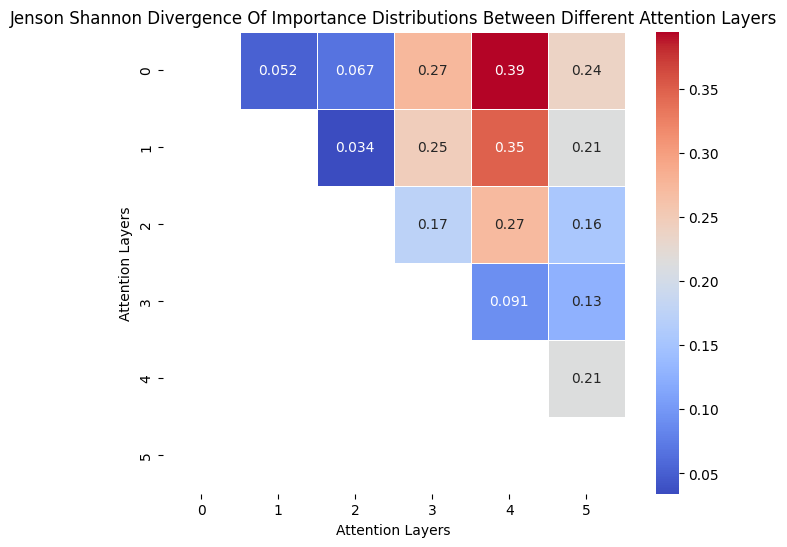

In [11]:
# Visualize the distances

results = np.array(results, dtype=np.float32)
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.5, mask=np.isnan(results))
plt.title('Jenson Shannon Divergence Of Importance Distributions Between Different Attention Layers')
plt.xlabel('Attention Layers')
plt.ylabel('Attention Layers')
plt.show()